# 

# Torch Finetune Models
In this notebook, several PyTorch models can be initialized as pretrained models. We can then finetune them based on our own datasets

### Imports
Import drive if using collab

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import tqdm
plt.style.use('ggplot')


### Print PyTorch versions and Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print("Device:", device)

PyTorch Version:  1.11.0+cu113
Torchvision Version:  0.12.0+cu113
Device: cuda:0


### Models:
* resnet
* alexnet
* vgg
* squeezenet
* densenet
* inception

### Hyperparameters

In [4]:
data_dir = "../datasets/final_dataset"
num_classes = 4
model_name = "densenet"
batch_size = 32
n_epochs = 10
path_to_save = "../weights/fire_detection_densenet_10epochs.pt" # .pt file extension

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

### Helper Functions

In [5]:
def unique_path(path):
    filename, extension = os.path.splitext(path)
    counter = 1

    while os.path.exists(path):
        path = filename + "_" + str(counter) + extension
        counter += 1

    return path

def train_model(model, dataloaders, criterion, optimizer, save_path, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0

    for epoch in range(num_epochs):
        print('-' * 50)
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 50)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                print("Training...")
            else:
                model.eval()   # Set model to evaluate mode
                print("\nValidating...")

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm.notebook.tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4 * loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}%'.format(phase, epoch_loss, epoch_acc * 100))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_epoch = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f} at epoch: {}'.format(best_acc * 100, epoch))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    # save vest model weights
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")

    return model, val_acc_history

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

### Load Model

In [6]:
# Initialize the model for this run
model_ft, input_size = initialize_model(
    model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

### Load Data

In [7]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

Initializing Datasets and Dataloaders...


### Optimizer

In [8]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 features.conv0.weight
	 features.norm0.weight
	 features.norm0.bias
	 features.denseblock1.denselayer1.norm1.weight
	 features.denseblock1.denselayer1.norm1.bias
	 features.denseblock1.denselayer1.conv1.weight
	 features.denseblock1.denselayer1.norm2.weight
	 features.denseblock1.denselayer1.norm2.bias
	 features.denseblock1.denselayer1.conv2.weight
	 features.denseblock1.denselayer2.norm1.weight
	 features.denseblock1.denselayer2.norm1.bias
	 features.denseblock1.denselayer2.conv1.weight
	 features.denseblock1.denselayer2.norm2.weight
	 features.denseblock1.denselayer2.norm2.bias
	 features.denseblock1.denselayer2.conv2.weight
	 features.denseblock1.denselayer3.norm1.weight
	 features.denseblock1.denselayer3.norm1.bias
	 features.denseblock1.denselayer3.conv1.weight
	 features.denseblock1.denselayer3.norm2.weight
	 features.denseblock1.denselayer3.norm2.bias
	 features.denseblock1.denselayer3.conv2.weight
	 features.denseblock1.denselayer4.norm1.weight
	 features.de

# Training

In [9]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, unique_path(path_to_save), num_epochs=n_epochs, is_inception=(model_name=="inception"))

--------------------------------------------------
Epoch 1/10
--------------------------------------------------
Training...


  0%|          | 0/185 [00:00<?, ?it/s]

train Loss: 0.4142 Acc: 85.1450%

Validating...


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.1097 Acc: 96.3359%

--------------------------------------------------
Epoch 2/10
--------------------------------------------------
Training...


  0%|          | 0/185 [00:00<?, ?it/s]

train Loss: 0.1400 Acc: 95.1162%

Validating...


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.0372 Acc: 98.7786%

--------------------------------------------------
Epoch 3/10
--------------------------------------------------
Training...


  0%|          | 0/185 [00:00<?, ?it/s]

train Loss: 0.0993 Acc: 96.5237%

Validating...


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.0244 Acc: 99.2366%

--------------------------------------------------
Epoch 4/10
--------------------------------------------------
Training...


  0%|          | 0/185 [00:00<?, ?it/s]

train Loss: 0.0714 Acc: 97.6090%

Validating...


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.0238 Acc: 99.2366%

--------------------------------------------------
Epoch 5/10
--------------------------------------------------
Training...


  0%|          | 0/185 [00:00<?, ?it/s]

train Loss: 0.0738 Acc: 97.4733%

Validating...


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.0148 Acc: 99.2366%

--------------------------------------------------
Epoch 6/10
--------------------------------------------------
Training...


  0%|          | 0/185 [00:00<?, ?it/s]

train Loss: 0.0642 Acc: 97.7107%

Validating...


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.0262 Acc: 98.7786%

--------------------------------------------------
Epoch 7/10
--------------------------------------------------
Training...


  0%|          | 0/185 [00:00<?, ?it/s]

train Loss: 0.0530 Acc: 98.3381%

Validating...


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.0132 Acc: 99.6947%

--------------------------------------------------
Epoch 8/10
--------------------------------------------------
Training...


  0%|          | 0/185 [00:00<?, ?it/s]

train Loss: 0.0430 Acc: 98.4568%

Validating...


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.0163 Acc: 99.5420%

--------------------------------------------------
Epoch 9/10
--------------------------------------------------
Training...


  0%|          | 0/185 [00:00<?, ?it/s]

train Loss: 0.0406 Acc: 98.6095%

Validating...


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.0137 Acc: 99.6947%

--------------------------------------------------
Epoch 10/10
--------------------------------------------------
Training...


  0%|          | 0/185 [00:00<?, ?it/s]

train Loss: 0.0389 Acc: 98.8130%

Validating...


  0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 0.0194 Acc: 99.2366%

Training complete in 15m 32s
Best val Acc: 99.694656 at epoch: 9
Model saved to ../weights/fire_detection_densenet_10epochs.pt


# Results

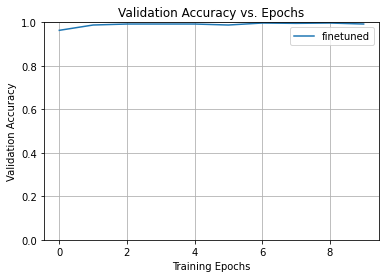

In [10]:
# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
final_hist = []

final_hist = [h.cpu().numpy() for h in hist]

plt.title("Validation Accuracy vs. Epochs")
plt.grid(True)
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(0, n_epochs), final_hist,label="finetuned")
plt.ylim((0,1.))
plt.legend()
plt.show()